# Класифікація зображень штучними нейронними мережами. 
Спочатку, для порівняння створимо класифікатор зображень використовуючи просту нейронну мережу. Дані для класифікації будуть використані з набору даних <a href='https://en.wikipedia.org/wiki/MNIST_database'>MNIST</a>. Перед використанням даних з простою нейронною мережею, їх треба перетворити у одновимірний масив.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

З PyTorch набір даних MNIST доступний через <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. При першому виклиre набір даних буде завантажено по вказаному шляху. Після цього torchvision буде завжди шукати локальну копію перед новим завантаженням.

### Визначення трансформацій.
Під час завантаження, до даних можна застосовувати різні трансформації (зміна форми, перетворення у тензори, нормалізація тощо).

In [2]:
transform = transforms.ToTensor()

### Завантаження тренувального набору.

In [3]:
train_data = datasets.MNIST(root='', train=True, download=True, transform=transform)
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: ToTensor()

### Завантаження тестового набору.

In [4]:
test_data = datasets.MNIST(root='', train=False, download=True, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: 
    Split: Test
    StandardTransform
Transform: ToTensor()

### Дослідження даних.

In [5]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLable:', label)

Shape: torch.Size([1, 28, 28]) 
Lable: 5


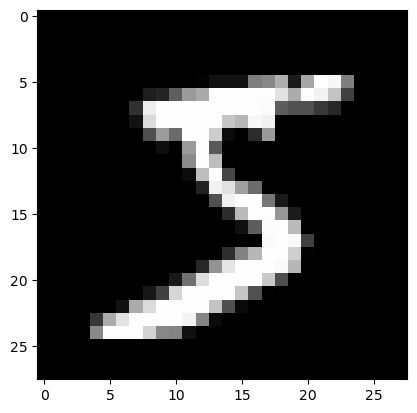

In [6]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gray")

### Завантаження даних частинами.
Тренувальний набір містить 60000 записів. Модель буде містити 784 вхідних нейронів, приховані шари по 120 та 84 нейрони та 10 вихідних нейронів. Враховуючи зміщення для кожного шару, загальна кількість параметрів у тренуванні:

$$
\begin{split}\quad(784\times120)+120+(120\times84)+84+(84\times10)+10 &=\\
94080+120+10080+84+840+10 &= 105,214\end{split}
$$
<br>

Завантажувати дані будемо частинами використовуючи <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'>DataLoader</a> клас.

In [7]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False) # задання shuffle значення True означає, що набір даних буде 
# перетасовуватись після кожної епохи.

### Створення моделі.
Для вирішення поставленої задачі буде використано <a href='https://en.wikipedia.org/wiki/Multilayer_perceptron'>багатошаровий персептрон.</a> Вхідний шар містить 784 нейрони (розмір зображення 28х28), кількість виходів 10, два приховані шари по 120 та 84 нейрони.

In [8]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [9]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Обрахунок кількості праметрів.

In [10]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [11]:
count_parameters(model)

 94080
   120
 10080
    84
   840
    10
______
105214


### Визначення функції обрахунку втрат та оптимізатора моделі.

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Сплющування даних.

In [13]:
for images, labels in train_loader:
    print('Розмір батчу:', images.size())
    break

Розмір батчу: torch.Size([100, 1, 28, 28])


In [14]:
images.view(100,-1).size()

torch.Size([100, 784])

### Тренування моделі.

In [15]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        y_pred = model(X_train.view(100, -1))
        loss = criterion(y_pred, y_train)
 
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            y_val = model(X_test.view(500, -1))

            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'Тривалість: {time.time() - start_time:.0f} секунд') # print the time elapsed            

epoch:  0  batch:  200 [ 20000/60000]  loss: 0.29955009  accuracy:  82.655%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.27258855  accuracy:  87.248%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.18182538  accuracy:  89.320%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.17060076  accuracy:  94.645%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.05018539  accuracy:  95.007%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.14207873  accuracy:  95.245%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.16335155  accuracy:  96.545%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.16890512  accuracy:  96.505%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.11178840  accuracy:  96.583%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.14472547  accuracy:  97.510%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.01248284  accuracy:  97.525%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.07453437  accuracy:  97.450%
epoch:  4  batch:  200 [ 20000/60000]  loss: 0.05818376  accuracy:  98.060%
epoch:  4  b

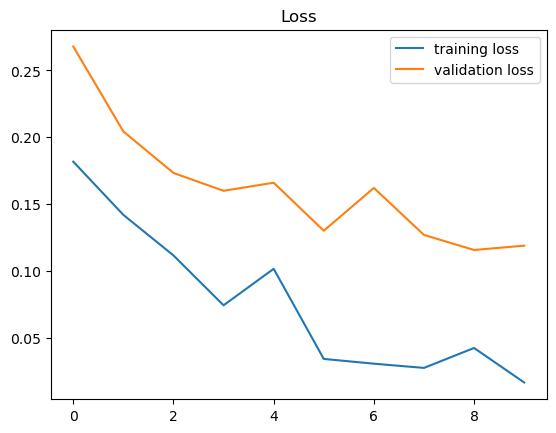

In [16]:
with torch.no_grad():
    plt.plot(train_losses, label='training loss')
    plt.plot(test_losses, label='validation loss')
    plt.title('Loss')
    plt.legend();

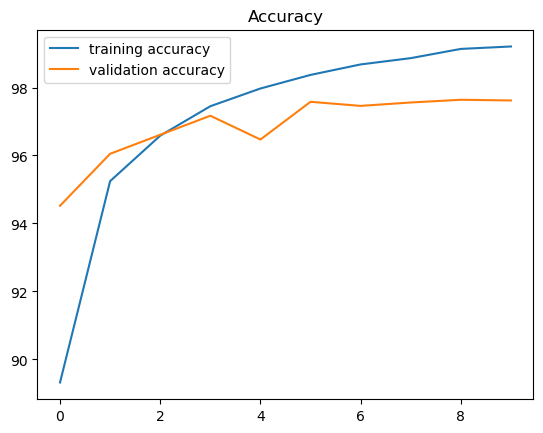

In [17]:
with torch.no_grad():
    plt.plot([t/600 for t in train_correct], label='training accuracy')
    plt.plot([t/100 for t in test_correct], label='validation accuracy')
    plt.title('Accuracy')
    plt.legend();

In [18]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Тест accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Тест accuracy: 9762/10000 =  97.620%


In [19]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 974    0    2    1    1    2    2    1    3    6]
 [   0 1123    0    0    1    0    4    7    0    2]
 [   1    3 1017   10    4    0    2   15    2    0]
 [   1    2    2  982    0   14    1    6    2    8]
 [   0    0    1    0  953    1    1    0    0    6]
 [   0    0    0    2    0  857    2    1    2    5]
 [   2    2    2    1    7    6  944    0    2    1]
 [   0    0    2    2    1    0    0  984    2    1]
 [   2    5    5   11    3   11    2    6  959   11]
 [   0    0    1    1   12    1    0    8    2  969]]


In [20]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
len(misses)

238

In [21]:
r = 12
row = iter(np.array_split(misses,len(misses)//r+1))

Індекс: [  18   33  115  149  151  193  241  247  274  321  340  381]
Значення: [   3    4    4    2    9    9    9    4    9    2    5    3]
Передбачення: [   8    0    9    9    8    8    8    2    3    7    3    7]


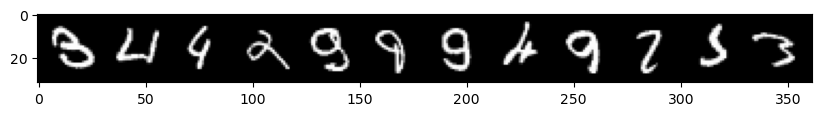

In [22]:
nextrow = next(row)
print("Індекс:", nextrow)
print("Значення:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Передбачення:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));